# Decision Tree for Record Data

## Introduction of DT

The decision tree is an attribute structure. Each leaf node of the decision tree represents a feature of the attribute set. Each branch is classified based on the size or category of a feature. The final result, that is, the final leaf node is a label classification, label classification.


Decision tree has several classification algorithms according to different classification methods. ID3 algorithm is a kind of decision tree, which is based on Occam's razor principle, that is, to do more with as few things as possible. The goal of each layer classification is to maximize the information gain, and the classification criteria of each layer are designed for this goal. C4.5 decision tree is optimized based on ID3 decision tree. Replacing the node division criteria with the information gain rate can handle continuous values, missing values, and pruning operations.


The pruning of decision trees is to reduce the complexity of decision trees and improve the generalization performance of decision trees. The generalization ability of the model can be reflected from the performance of the verification set.

# Preparations

**import python packages and read data from csv file**

In [200]:
#LOAD RELEVANT PACKAGES
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as  pd
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support

In [133]:
df=pd.read_csv("travel_mode_choice.csv")

In [135]:
df.head()

,TTME,INVC,INVT,GC,HINC,PSIZE,choice
0,40,20,345,57,20,1,2
1,45,148,115,160,45,1,1
2,20,19,325,55,26,1,2
3,15,38,255,66,26,1,2
4,20,21,300,54,6,1,2


This data is aboat people's travel mode choice and it contains 151 lines. There are 3 different travel mode choice in this data: "1" represents for air, "2" for train, and "3" for bus. As for X variables (features), there are 6 variables in total interpreted below: \

TTME - terminal waiting time\
INVC - in vehicle cost for all stages\
INVT - travel time (in-vehicle time) for all stages\
GC - generalized cost measure:invc+(invt*value of travel time savings)\
HINC - household income\
PSIZE - traveling group size\

The goal of this decision tree model is to precisely predict people's travel mode choice according to those X variables.


## Data exploration

First, let's have a look at the distribution of the target variable: choice

In [136]:
df["choice"].value_counts()

2    63
1    58
3    30
Name: choice, dtype: int64

In [138]:
X=df.loc[:,df.columns!="choice"]
Y=df.loc[:,"choice"]

Then I plot the heat map of the correlation matrix to see the relationship among different variables.

            TTME      INVC      INVT        GC      HINC    PSIZE     choice
TTME    1.000000  0.464165 -0.152421  0.309941  0.142177  0.070189 -0.384252
INVC    0.464165  1.000000 -0.429092  0.550372  0.362047 -0.040891 -0.693269
INVT   -0.152421 -0.429092  1.000000  0.484061 -0.241788 -0.045246  0.678051
GC      0.309941  0.550372  0.484061  1.000000  0.131839  0.079697 -0.057761
HINC    0.142177  0.362047 -0.241788  0.131839  1.000000 -0.017023 -0.294000
PSIZE   0.070189 -0.040891 -0.045246  0.079697 -0.017023  1.000000 -0.078319
choice -0.384252 -0.693269  0.678051 -0.057761 -0.294000 -0.078319  1.000000


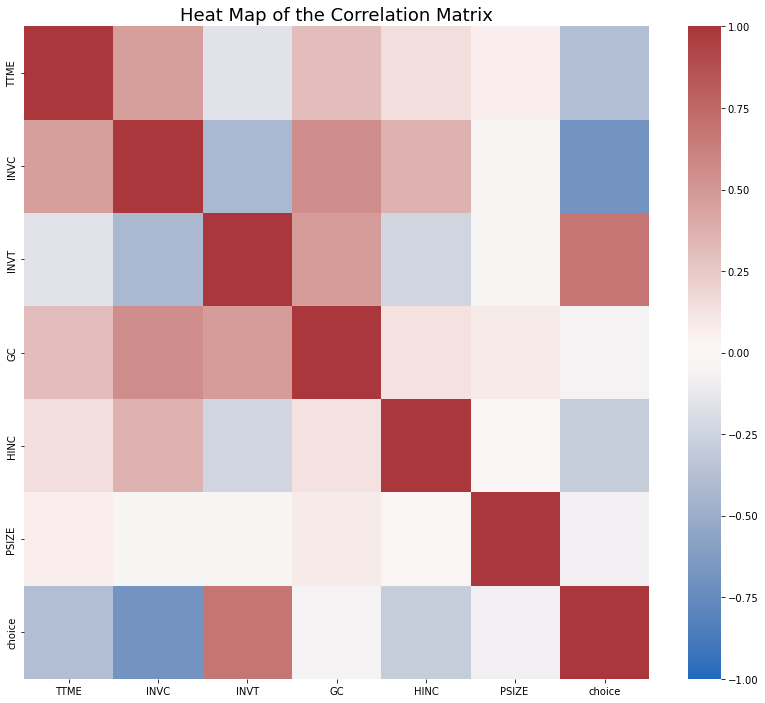

In [139]:
print(df.corr())
fig,axes = plt.subplots(1, 1, num="stars",figsize=(14, 12))
axes = sns.heatmap(df.corr(), vmin=-1, vmax=1,cmap="vlag")
axes.set_title("Heat Map of the Correlation Matrix", fontsize=18)
#plt.show()
plt.savefig("correlation.png",dpi=200)

## Data modeling
In data modeling part, we need to split the data first. Ratio of test data set is 0.2.

In [150]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
print(type(X_train),X_train.shape)
print(type(Y_train),Y_train.shape)
print(type(X_test),X_test.shape)
print(type(Y_test),Y_test.shape)

<class 'pandas.core.frame.DataFrame'> (120, 6)
<class 'pandas.core.series.Series'> (120,)
<class 'pandas.core.frame.DataFrame'> (31, 6)
<class 'pandas.core.series.Series'> (31,)


Then it's time to use decision tree model to fit the train data. We first use default hyperparameters.

In [158]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train,Y_train)
yp_train = model.predict(X_train)
yp_test = model.predict(X_test)

In [185]:
def confusion_plot(y_data,y_pred):
    print("ACCURACY:",sum(y_pred==y_data)/len(y_data))
    con_matrix=confusion_matrix(y_data,y_pred,labels=model.classes_)
    print(con_matrix)
    disp=ConfusionMatrixDisplay(confusion_matrix=con_matrix,display_labels=model.classes_)
    disp.plot()
    plt.show()

------TRAINING------
ACCURACY: 1.0
[[45  0  0]
 [ 0 51  0]
 [ 0  0 24]]


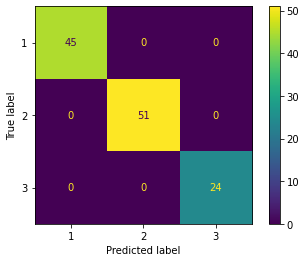

------TEST------
ACCURACY: 0.7096774193548387
[[10  2  1]
 [ 0 11  1]
 [ 0  5  1]]


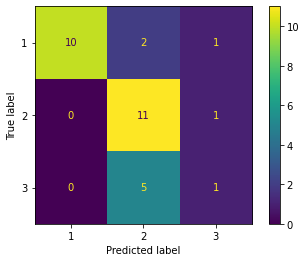

In [159]:
print("------TRAINING------")
confusion_plot(Y_train,yp_train)
print("------TEST------")
confusion_plot(Y_test,yp_test)

According to these two confusion matrix, we can see that the accuracy on train data reaches an incredible 1.0. Nonetheless, test accuracy is much lower, which means this decision tree model with default hyperparameter faces severe overfitting problem.

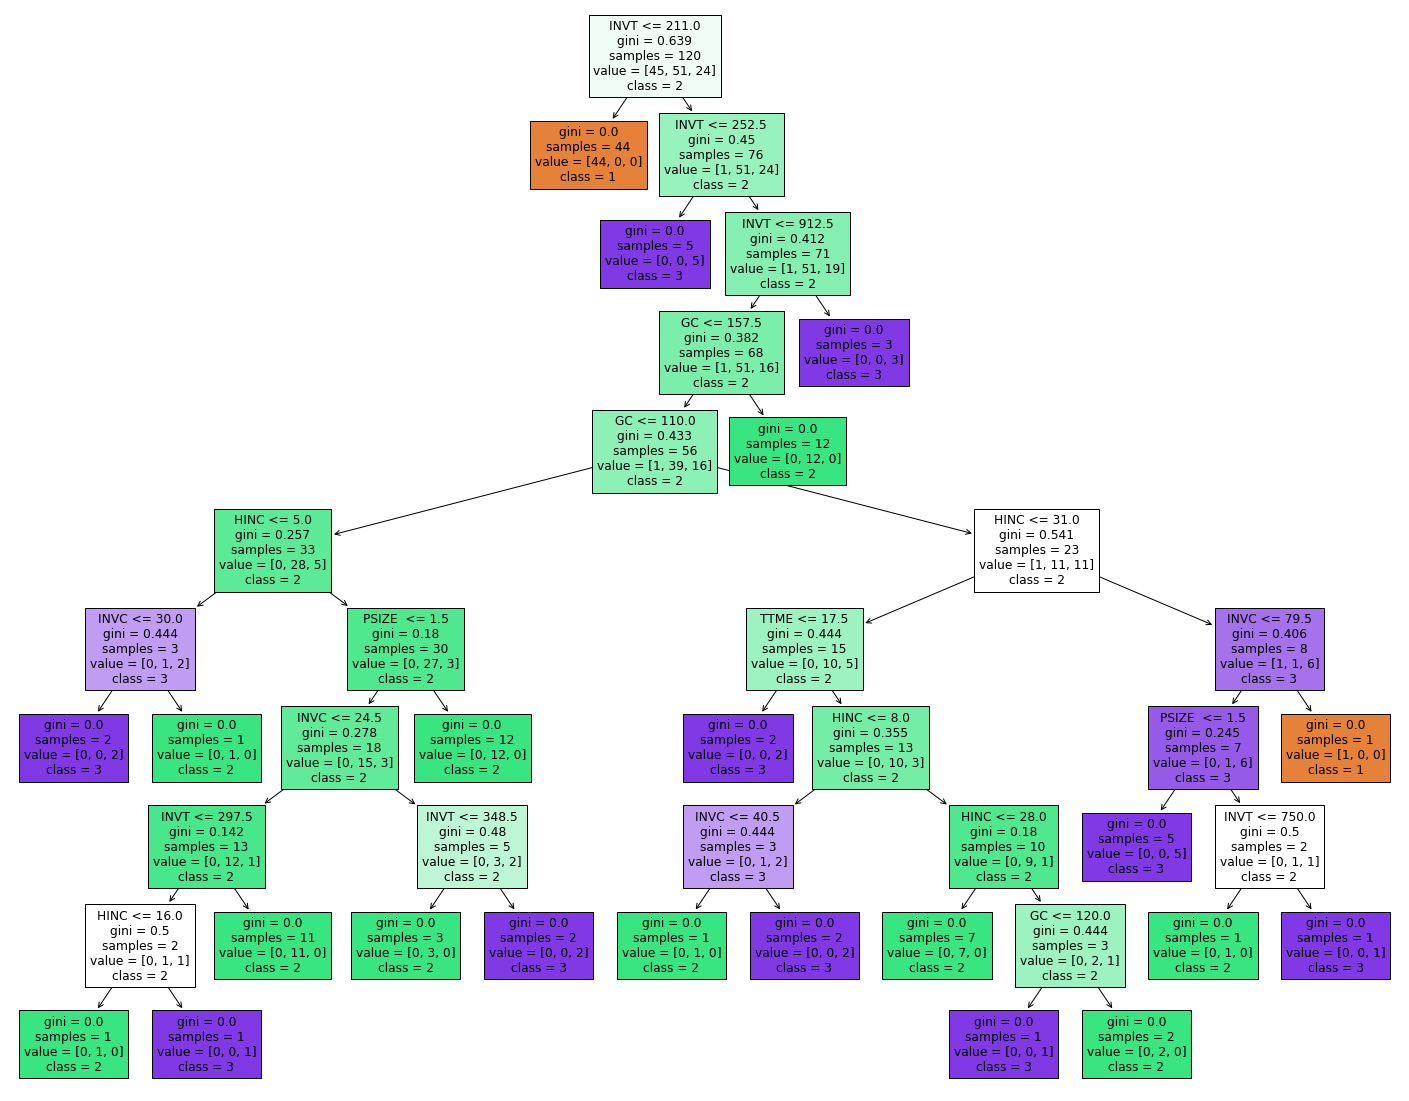

In [155]:
def plot_tree(model,X,Y):
    fig=plt.figure(figsize=(25,20))
    _=tree.plot_tree(model,
                   feature_names=X_train.columns,
                   class_names=["1","2","3"],
                   filled=True)
    plt.show()
    
plot_tree(model,X_train,Y_train)

This graph above is a clear illustration of this decision tree model on train data. It is obvious this tree is so deep that it fits every single point in train data, and that's why it can achieve a 100 percent accuracy (but this is actually useless)

## Model tuning

In order to overcome the overfitting problem and search for an optimal model, I will consider two hyperparameter to tune: max depth of the tree, and splitting criterion. First we start with the former one.

In [166]:
test_results=[]
train_results=[]

for num_layer in range(1,20):
    model = tree.DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(X_train,Y_train)

    yp_train=model.predict(X_train)
    yp_test=model.predict(X_test)

    test_results.append([num_layer,accuracy_score(Y_test, yp_test)])
    train_results.append([num_layer,accuracy_score(Y_train, yp_train)])

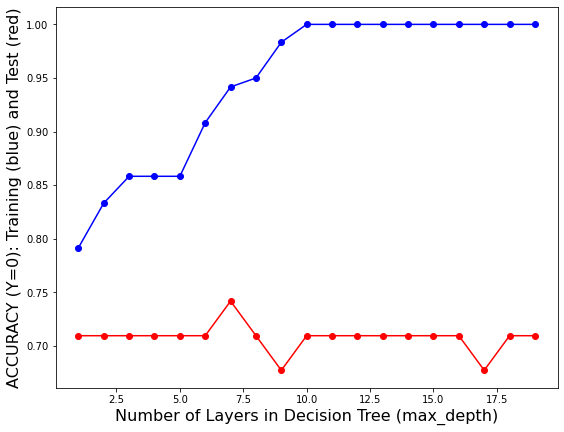

In [167]:
fig,axes=plt.subplots(1,1,figsize=(9,7))
fs=16
axes.plot(np.array(train_results)[:,0],np.array(train_results)[:,1],"b-o")
axes.plot(np.array(test_results)[:,0],np.array(test_results)[:,1],"r-o")
axes.set_xlabel("Number of Layers in Decision Tree (max_depth)", fontsize=fs)
axes.set_ylabel("ACCURACY (Y=0): Training (blue) and Test (red)", fontsize=fs)

plt.show()

According to this plot, it is clear that when max depth is greater than 7, accuracy on train data keep enhancing but performance on test data does not improve anymore. Thus, I choose 7 as the final value of this hyperparameter.

Next, I will successively test two splitting criterion: "gini", and "entropy", fixing max depth to be 7. 

In [176]:
criterion_list=["gini", "entropy"]

In [178]:
test_results=[]
train_results=[]

for crit in criterion_list:
    model = tree.DecisionTreeClassifier(criterion=crit,max_depth=7)
    model = model.fit(X_train,Y_train)

    yp_train=model.predict(X_train)
    yp_test=model.predict(X_test)

    test_results.append(accuracy_score(Y_test, yp_test))
    train_results.append(accuracy_score(Y_train, yp_train))

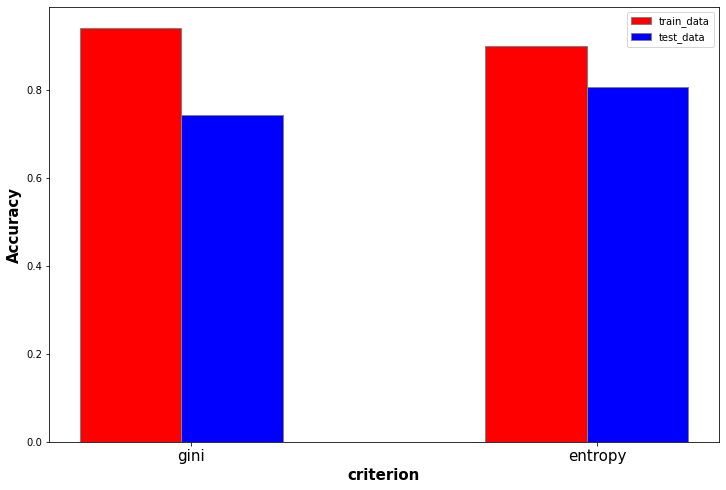

In [184]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Set position of bar on X axis
br1 = np.arange(len(train_results))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, train_results, color ='r', width = barWidth,
        edgecolor ='grey', label ='train_data')
plt.bar(br2, test_results, color ='b', width = barWidth,
        edgecolor ='grey', label ='test_data')
 
# Adding Xticks
plt.xlabel('criterion', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth - 0.1 for r in range(len(train_results))],
        ['gini','entropy'],fontsize=15)
 
plt.legend()
plt.show()

From this comparison, we can notice that model with "gini" criterion perform better on train data while "entropy" model have higher accuracy on test data. Therefore, we finally choose "entropy" as the criterion.

## Baseline comparison

Additionally, let's compare this decision tree model with baseline model(random classifier):

In [190]:
def generate_label_data(class_labels, weights,N=10000):
    y=random.choices(class_labels, weights = weights, k = N)
    return y

In [201]:
def random_classifier(y_data):
    ypred=[];
    max_label=np.max(y_data); #print(max_label)
    for i in range(0,len(y_data)):
        ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))

    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))

y=generate_label_data([0,1,2],[0.42,0.38,0.20],10000)
random_classifier(y)

-----RANDOM CLASSIFIER-----
count of prediction: dict_values([3432, 3312, 3256])
probability of prediction: [0.3432 0.3312 0.3256]
accuracy 0.3305
percision, recall, fscore, (array([0.43206522, 0.37407862, 0.19114219]), array([0.33426769, 0.31976897, 0.3434555 ]), array([0.37692612, 0.3447983 , 0.2456009 ]), array([4281, 3809, 1910]))


There's no doubt that our decision tree model performs much better than baseline model (random classifier).

## Final result and conclusion

In [202]:
model = tree.DecisionTreeClassifier(criterion="entropy",max_depth=7)
model = model.fit(X_train,Y_train)

yp_train=model.predict(X_train)
yp_test=model.predict(X_test)

------TRAINING------
ACCURACY: 0.9
[[45  0  0]
 [ 0 41 10]
 [ 0  2 22]]


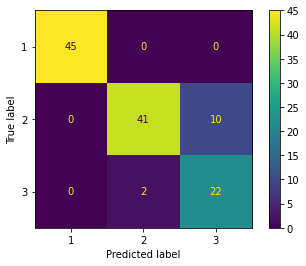

------TEST------
ACCURACY: 0.8387096774193549
[[12  0  1]
 [ 1 11  0]
 [ 0  3  3]]


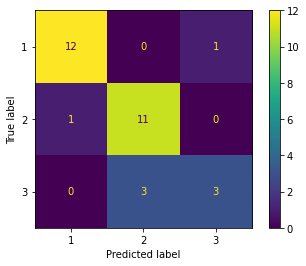

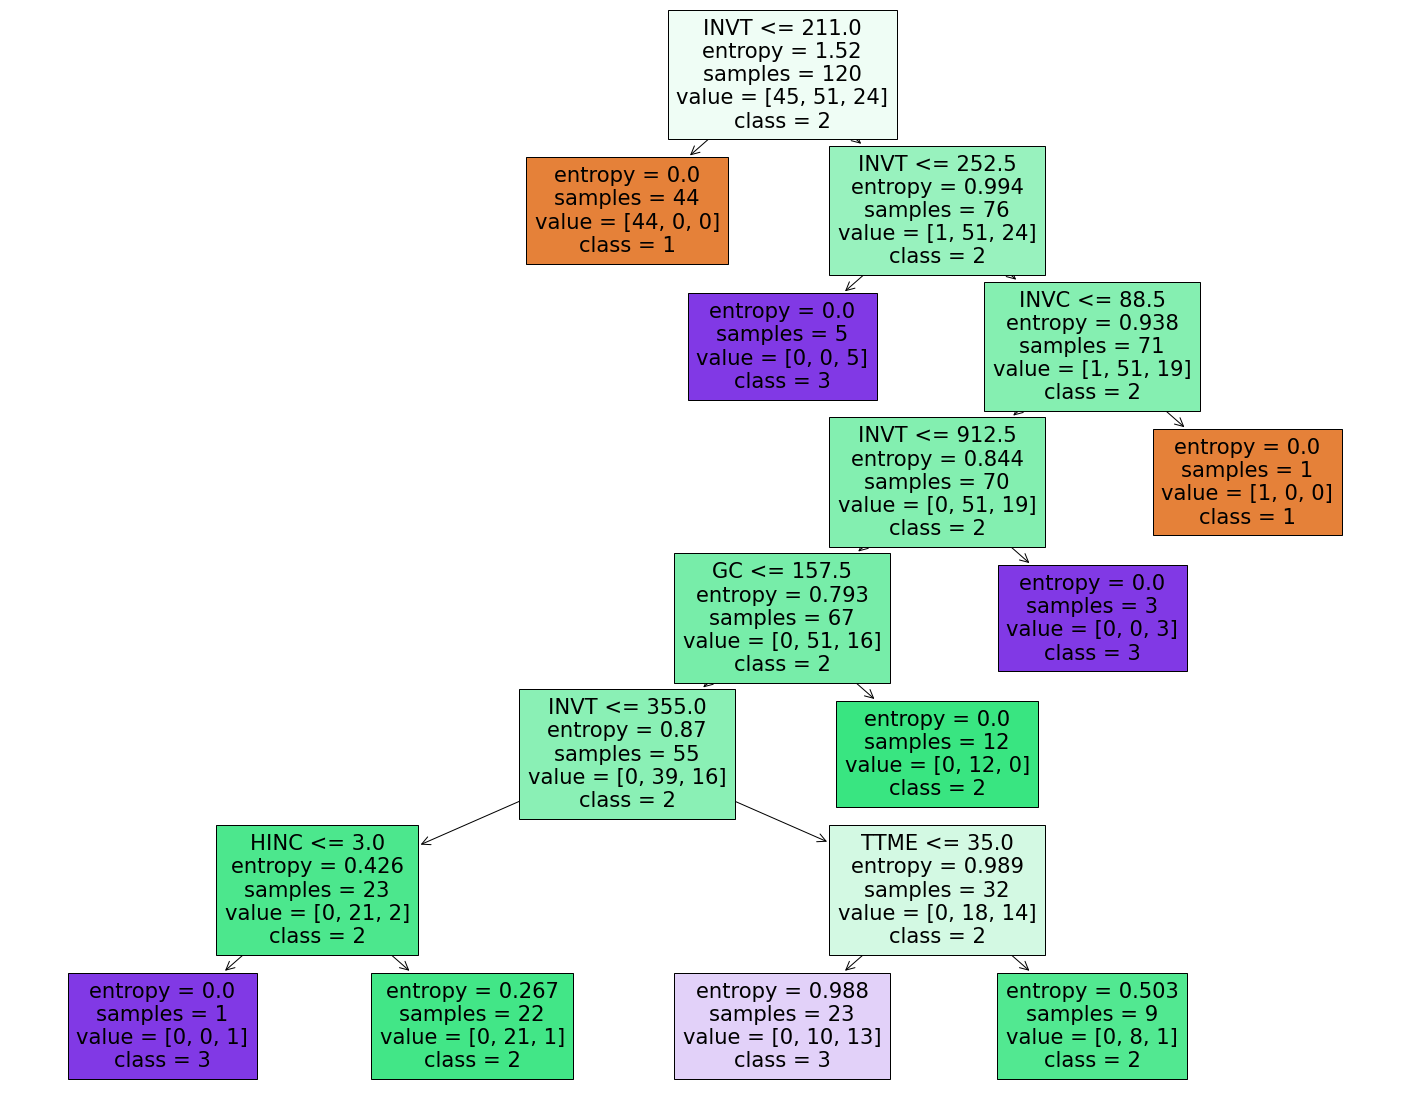

In [204]:
print("------TRAINING------")
confusion_plot(Y_train,yp_train)
print("------TEST------")
confusion_plot(Y_test,yp_test)

plot_tree(model,X_test,Y_test)

According to model results and confusion matrix above, the accuracy on test data is greater than 0.8, which means this decision tree model performs as an excellent classifier to recognize three different catagories of travel mode "air", "train", and "bus" according to relevant data.

One advantage of decision tree model is that the result of this tree model is interpretable. For instance, from the tree plot above we notice that in the root node, the model split this data by "whether total travel time $\leq$ 211 minutes". It makes sense that taking the train or long distance bus cost much more time than airplane, that's why we immediately get a pure leaf under this root node.

However, this data set is relatively small, and therefore the decision tree model might not be robust and stable enough. In future research, it will be a possible way to first do some data augmentation.